<a href="https://colab.research.google.com/github/MiHess/cxr-bse/blob/master/first_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import numpy as np
import PIL
import logging
import random
import matplotlib.pyplot as plt
plt.style.use('default')

from PIL import ImageOps
from skimage import exposure
from collections import defaultdict
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint



Using TensorFlow backend.


In [0]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
bse_path = "/content/drive/My Drive/dev/bse"

jsrt_bse_path = os.path.join(bse_path, "data", "jsrt_bse")

jsrt_path = os.path.join(bse_path, "data", "jsrt")

version = "v1"

checkpoint_path = os.path.join(bse_path, "ml", version, "checkpoints")
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)


In [0]:
def _load_grayscale_image(filepath):
    """
    """
    img_array = np.array(load_img(filepath))[:,:,1]
    
    return img_array.reshape(img_array.shape + (1, ))  
    

def get_train_test_data(X_images_path, y_images_path, test_fraction=0.2):
    """ Loads all images from disk to memory and returns them as numpy array.
    """
    EXPECTED_TOTAL_NUMBER = 247
    
    X_image_filepaths = sorted(glob.glob(os.path.join(X_images_path, "*.png")))
    y_image_filepaths = sorted(glob.glob(os.path.join(y_images_path, "*.png")))
    
    if (len(X_image_filepaths) != EXPECTED_TOTAL_NUMBER) or (len(y_image_filepaths) != EXPECTED_TOTAL_NUMBER):
        raise ValueError(f"expected {EXPECTED_TOTAL_NUMBER} images. "
            f"Found {len(X_image_filepaths)} X and {len(y_image_filepaths)} y images, respectively.")
    else:
        logger.info(f"Found {len(X_image_filepaths)} X images and {len(y_image_filepaths)} y images.")    

    X_images = []
    y_images = []
    for X_image_filepath, y_image_filepath in zip(X_image_filepaths, y_image_filepaths):
        if os.path.basename(X_image_filepath) == os.path.basename(y_image_filepath):
            X_images.append(_load_grayscale_image(X_image_filepath))
            y_images.append(_load_grayscale_image(y_image_filepath))
        else:
            raise ValueError(f"image names do not match: {X_image_filepath} and {y_image_filepath}")
        
    test_idc = random.sample(range(EXPECTED_TOTAL_NUMBER), int(EXPECTED_TOTAL_NUMBER * test_fraction))
    train_idc = [idx for idx in range(EXPECTED_TOTAL_NUMBER) if idx not in test_idc]
    
    return np.array(X_images)[train_idc], np.array(y_images)[train_idc], \
        np.array(X_images)[test_idc], np.array(y_images)[test_idc]
        


In [0]:
X_train, y_train, X_test, y_test = get_train_test_data(jsrt_path, jsrt_bse_path)

In [0]:
seed = 1
batch_size=16


basic_datagen = ImageDataGenerator(
    rescale=1./255)

val_X_generator = basic_datagen.flow(
    X_test,
    batch_size=batch_size,
    seed=seed)

val_y_generator = basic_datagen.flow(
    y_test,
    batch_size=batch_size,
    seed=seed)


augmenting_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_X_generator = augmenting_datagen.flow(
    X_train, 
    batch_size=batch_size, 
    seed=seed)

train_y_generator = augmenting_datagen.flow(
    y_train, 
    batch_size=batch_size, 
    seed=seed)


train_generator = zip(train_X_generator, train_y_generator)
val_generator = zip(val_X_generator, val_y_generator)

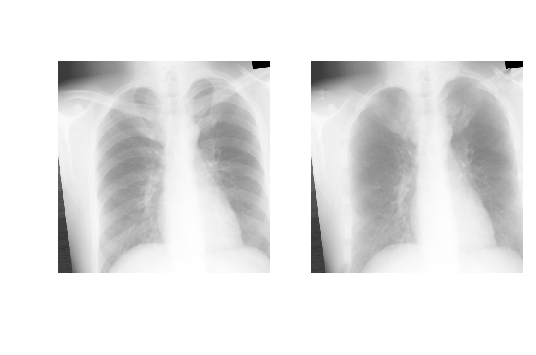

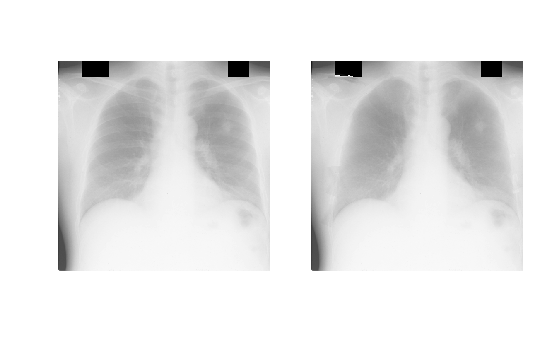

In [9]:
image, image_bse = next(train_generator)

examples = 1
fig, axes = plt.subplots(examples, 2, figsize=(6, 4), sharex=True, sharey=True)
for i in range(examples):
    axes[0].imshow(image[i][:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(image_bse[i][:,:,0], cmap='gray')
    axes[1].axis('off')

image, image_bse = next(val_generator)

examples = 1
fig, axes = plt.subplots(examples, 2, figsize=(6, 4), sharex=True, sharey=True)
for i in range(examples):
    axes[0].imshow(image[i][:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(image_bse[i][:,:,0], cmap='gray')
    axes[1].axis('off')


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(512, 512, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
weights_filename = os.path.join(checkpoint_path, os.listdir(checkpoint_path)[-1])
print(weights_filename)
autoencoder.load_weights(weights_filename)

/content/drive/My Drive/dev/bse/ml/v1/checkpoints/weights.10-0.47.hdf5


In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     147584    
__________

In [0]:
checkpoint_filename = os.path.join(checkpoint_path, "weights.{epoch:02d}-{val_loss:.2f}.hdf5")

checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint, ]

In [30]:
epochs=20

autoencoder_train = autoencoder.fit_generator(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=100,
    validation_steps=100,
    epochs=epochs,
    callbacks=callbacks_list)

Epoch 1/20
100/100 [==============================] - 108s 1s/step - loss: 0.4982 - val_loss: 0.4673
Epoch 2/20
100/100 [==============================] - 103s 1s/step - loss: 0.4862 - val_loss: 0.4740
Epoch 3/20
100/100 [==============================] - 103s 1s/step - loss: 0.4802 - val_loss: 0.4827
Epoch 4/20
100/100 [==============================] - 102s 1s/step - loss: 0.5062 - val_loss: 0.4729
Epoch 5/20
100/100 [==============================] - 102s 1s/step - loss: 0.4813 - val_loss: 0.4741
Epoch 6/20
100/100 [==============================] - 103s 1s/step - loss: 0.5004 - val_loss: 0.4862
Epoch 7/20
100/100 [==============================] - 102s 1s/step - loss: 0.4843 - val_loss: 0.4865
Epoch 8/20
100/100 [==============================] - 102s 1s/step - loss: 0.4849 - val_loss: 0.4896
Epoch 9/20
100/100 [==============================] - 102s 1s/step - loss: 0.4817 - val_loss: 0.4766
Epoch 10/20
100/100 [==============================] - 102s 1s/step - loss: 0.4840 - val_lo

In [15]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored

In [0]:
X, y = next(val_generator)
pred = autoencoder.predict(X)


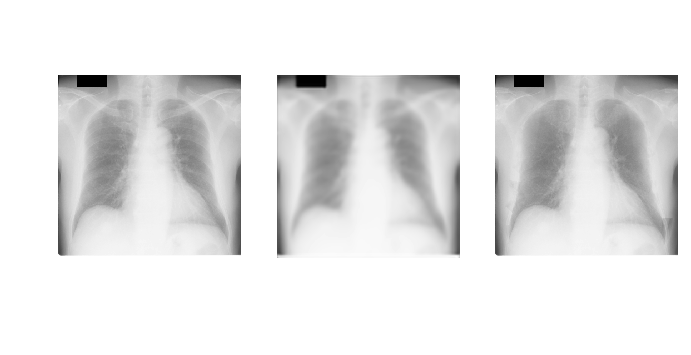

In [31]:
image, image_bse = next(val_generator)

examples = 1
fig, axes = plt.subplots(examples, 3, figsize=(8, 4), sharex=True, sharey=True)
for i in range(examples):
    axes[0].imshow(X[0,:,:,0], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(pred[0,:,:,0], cmap='gray')
    axes[1].axis('off')
    axes[2].imshow(y[0,:,:,0], cmap='gray')
    axes[2].axis('off')    

In [0]:
pred = autoencoder.predict(test_data)
